In [5]:
import os
import pickle
import sys
from copy import deepcopy

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from gymnasium.wrappers import RescaleAction
from torch import nn
from torch.distributions import Normal
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, random_split

sys.path.append(os.path.abspath(".."))

from rlib.algorithms.sac import sac
from rlib.common.buffer import ReplayBuffer, RolloutBuffer
from rlib.common.evaluation import get_trajectory, save_frames_as_gif, validation
from rlib.common.logger import TensorBoardLogger
from rlib.common.policies import DeterministicMlpPolicy, MlpQCritic, StochasticMlpPolicy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

min_action, max_action = -1, 1
env = RescaleAction(env, min_action, max_action)

In [7]:
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
trajectory_len = 200

print(obs_dim, action_dim)

3 1


### Expert

In [316]:
with open("./models/pendulum_stoc_expert", "rb") as file:
    expert_actor = pickle.load(file)

In [317]:
validation(env, expert_actor)

-149.28415624836117

In [318]:
rb = RolloutBuffer()

In [319]:
rb.collect_rollouts(env, expert_actor, trajectories_n=500)

In [320]:
data = rb.get_data()
expert_trajectories = rb.get_trajectories(data)

In [321]:
len(expert_trajectories)

500

In [366]:
expert_trajectories[0]["q_estimations"]

tensor([[-1.1392e+02],
        [-1.0944e+02],
        [-1.0428e+02],
        [-9.8044e+01],
        [-9.0373e+01],
        [-8.0946e+01],
        [-6.9525e+01],
        [-5.7417e+01],
        [-4.6698e+01],
        [-3.7439e+01],
        [-2.9644e+01],
        [-2.3244e+01],
        [-1.8111e+01],
        [-1.4069e+01],
        [-1.0930e+01],
        [-8.5084e+00],
        [-6.6467e+00],
        [-5.2133e+00],
        [-4.1044e+00],
        [-3.2487e+00],
        [-2.6214e+00],
        [-2.1907e+00],
        [-1.8914e+00],
        [-1.6815e+00],
        [-1.5321e+00],
        [-1.4331e+00],
        [-1.3696e+00],
        [-1.3252e+00],
        [-1.2922e+00],
        [-1.2677e+00],
        [-1.2500e+00],
        [-1.2374e+00],
        [-1.2283e+00],
        [-1.2216e+00],
        [-1.2166e+00],
        [-1.2129e+00],
        [-1.2098e+00],
        [-1.2071e+00],
        [-1.2046e+00],
        [-1.2023e+00],
        [-1.2001e+00],
        [-1.1979e+00],
        [-1.1955e+00],
        [-1

In [322]:
with open("./models/expert_trajectories", "wb") as file:
    pickle.dump(expert_trajectories, file)

### Expert Data

In [323]:
with open("./models/expert_trajectories", "rb") as file:
    expert_trajectories = pickle.load(file)

In [342]:
len(expert_trajectories)

500

### Decision Transformer

In [348]:
class DecisionTransformer(nn.Module):
    def __init__(
        self,
        obs_dim: int,
        action_dim: int,
        trajectory_len: int,
        embedding_dim: int = 32,
        nhead: int = 4,
        num_layers: int = 3,
    ):
        super().__init__()

        self.R_embedding = nn.Linear(1, embedding_dim)
        self.s_embedding = nn.Linear(obs_dim, embedding_dim)
        self.a_embedding = nn.Linear(action_dim, embedding_dim)

        self.t_embedding = nn.Embedding(trajectory_len, embedding_dim)

        decoder_layer = nn.TransformerEncoderLayer(
            embedding_dim,
            nhead,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(decoder_layer, num_layers)
        self.head = nn.Linear(embedding_dim, action_dim)

    def forward(self, R, s, a, t):
        """
        Args:
            R (torch.Tensor): (B, T, 1)
            s (torch.Tensor): (B, T, obs_dim)
            a (torch.Tensor): (B, T, action_dim)
            t (torch.Tensor): (B, T, 1)

        Returns:
            a_pred: (torch.Tensor): (B, T, action_dim)
        """
        t_emb = self.t_embedding(t.squeeze()).squeeze()

        R_emb = self.R_embedding(R) + t_emb  # (B, T, C)
        s_emb = self.s_embedding(s) + t_emb  # (B, T, C)
        a_emb = self.a_embedding(a) + t_emb  # (B, T, C)

        B, T, C = R_emb.shape

        token_emb = torch.stack((R_emb, s_emb, a_emb), dim=2)  # (B, 3, T, C)
        token_emb = token_emb.view(B, 3 * T, C)  # (B, 3T, C)

        mask = nn.Transformer.generate_square_subsequent_mask(3 * T, device="cuda")

        hidden_states = self.transformer.forward(token_emb, mask)  # (B, 3T, C)
        a_hidden = hidden_states[:, 2::3, :]  # (B, T, C)
        a_pred = torch.tanh(self.head(a_hidden))  # (B, T, action_dim)

        return a_pred

In [349]:
class TrajectoryDataset(Dataset):
    def __init__(self, trajectories, K):
        self.trajectories = trajectories
        self._add_timesteps()

        self.sequences = []

        for traj in self.trajectories:
            traj_len = traj["observations"].shape[0]
            for i in range(0, traj_len - K + 1):
                R = traj["q_estimations"][i : i + K]
                s = traj["observations"][i : i + K]
                a = traj["actions"][i : i + K]
                t = traj["timesteps"][i : i + K]

                self.sequences.append((R, s, a, t))

    def __getitem__(self, i):
        return self.sequences[i]

    def __len__(self):
        return len(self.sequences)

    def _add_timesteps(self):
        for traj in self.trajectories:
            traj_len = traj["observations"].shape[0]
            traj["timesteps"] = torch.arange(0, traj_len).reshape(-1, 1)

In [414]:
def evaluation(
    model: DecisionTransformer, 
    env: gym.Env, 
    target_return: float = -200, 
    K: int = 5, 
    device: str = "cuda",
    visualize: bool = False,
    
):
    model.eval()
    obs, _ = env.reset()
    action = env.action_space.sample()

    R = torch.tensor(target_return, dtype=torch.float32, device=device).reshape(1, 1, 1)
    s = torch.tensor(obs, dtype=torch.float32, device=device).reshape(1, 1, -1)
    a = torch.tensor(action, dtype=torch.float32, device=device).reshape(1, 1, -1)
    t = torch.tensor(0, device=device).reshape(1, 1, 1)

    rewards = []
    frames = []

    while True:
        with torch.no_grad():
            a_pred = model.forward(R, s, a, t)[:, -1, :]
        a_pred = a_pred.reshape(1, 1, -1)

        action = a_pred.squeeze().cpu().detach().numpy()

        print(
            action, end="\n \n"
        )

        next_obs, reward, terminated, truncated, _ = env.step(action)

        '''
        print(
            expert_actor.predict(next_obs.squeeze(), deterministic=True)
        )
        '''

        rewards.append(reward)

        next_obs = torch.tensor(next_obs, dtype=torch.float32, device=device).reshape(1, 1, -1)
        reward = torch.tensor(reward, dtype=torch.float32, device=device).reshape(1, 1, 1)

        return_to_go = R[:, -1, :] - reward
        timestep = t[:, -1, :] + 1
        timestep = timestep.reshape(1, 1, 1)

        R = torch.cat((R, return_to_go), dim=1)[:, -K:, :]
        s = torch.cat((s, next_obs), dim=1)[:, -K:, :]
        a = torch.cat((a, a_pred), dim=1)[:, -K:, :]
        t = torch.cat((t, timestep), dim=1)[:, -K:, :]

        print(
            R, s, a, t
        )

        if visualize:
            frames.append(env.render())

        if terminated or truncated:
            break

    if visualize:
        print("saving...")
        save_frames_as_gif(frames)

    return sum(rewards)

In [386]:
def train(
    decision_transformer: DecisionTransformer,
    optimizer: Adam,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    total_epochs: int = 100,
    max_return: float = -200,
    K: int = 5,
    device: str = "cuda",
):
    logger = TensorBoardLogger(log_dir="./tb_logs/dt_")

    for epoch_n in range(total_epochs):
        train_losses, test_losses = [], []

        decision_transformer.train()
        for R, s, a, t in train_dataloader:
            R, s, a, t = R.to(device), s.to(device), a.to(device), t.to(device)
            a_preds = decision_transformer(R, s, a, t)

            batch_loss = ((a_preds - a) ** 2).mean()
            train_losses.append(batch_loss.item())

            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        decision_transformer.eval()
        with torch.no_grad():
            for R, s, a, t in test_dataloader:
                R, s, a, t = R.to(device), s.to(device), a.to(device), t.to(device)
                a_preds = decision_transformer(R, s, a, t)
                batch_loss = ((a_preds - a) ** 2).mean()
                test_losses.append(batch_loss.item())

        loss = {}
        loss["train"] = sum(train_losses) / len(train_losses)
        loss["test"] = sum(test_losses) / len(test_losses)
        logger.log_scalars(loss, epoch_n)

        metrics = {}
        metrics["traj_reward"] = evaluation(decision_transformer, env, max_return, K)
        logger.log_scalars(metrics, epoch_n)


### Training

In [352]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [353]:
dataset = TrajectoryDataset(expert_trajectories, K=30)
print(len(dataset))

85500


In [354]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, (train_size, test_size))
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [355]:
decision_transformer = DecisionTransformer(obs_dim, action_dim, trajectory_len).to(
    device
)
optimizer = Adam(decision_transformer.parameters(), lr=1e-3)

In [ ]:
train(
    decision_transformer,
    optimizer,
    train_dataloader,
    test_dataloader,
    total_epochs=100,
    device=device,
    K=30,
)

In [360]:
evaluation(decision_transformer, env, target_return=-200, K=30)

tensor([[[-200.0000],
         [-199.4629]]], device='cuda:0') tensor([[[ 0.7895, -0.6137, -0.9986],
         [ 0.7472, -0.6646, -1.3242]]], device='cuda:0') tensor([[[0.4292],
         [0.4491]]], device='cuda:0') tensor([[[0],
         [1]]], device='cuda:0')
tensor([[[-200.0000],
         [-199.4629],
         [-198.7582]]], device='cuda:0') tensor([[[ 0.7895, -0.6137, -0.9986],
         [ 0.7472, -0.6646, -1.3242],
         [ 0.6887, -0.7250, -1.6825]]], device='cuda:0') tensor([[[0.4292],
         [0.4491],
         [0.4673]]], device='cuda:0') tensor([[[0],
         [1],
         [2]]], device='cuda:0')
tensor([[[-200.0000],
         [-199.4629],
         [-198.7582],
         [-197.8163]]], device='cuda:0') tensor([[[ 0.7895, -0.6137, -0.9986],
         [ 0.7472, -0.6646, -1.3242],
         [ 0.6887, -0.7250, -1.6825],
         [ 0.6096, -0.7927, -2.0821]]], device='cuda:0') tensor([[[0.4292],
         [0.4491],
         [0.4673],
         [0.4803]]], device='cuda:0') tensor([[[

array([[-1546.4186]], dtype=float32)

In [362]:
(500 * 200 * 6 * 4) / 1024

2343.75

In [338]:
len(expert_trajectories)

500

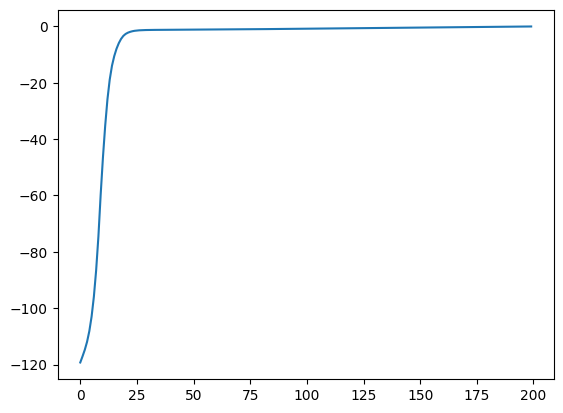

In [263]:
traj = expert_trajectories[99]
i = 100
K = 5

# print(traj["q_estimations"].detach().numpy())
plt.plot(traj["q_estimations"].detach().numpy())

In [279]:
i = 50

In [367]:
R = traj["q_estimations"][i: i + K].unsqueeze(0)
s = traj["observations"][i: i + K].unsqueeze(0)
a = traj["actions"][i: i + K].unsqueeze(0)
t = traj["timesteps"][i: i + K].unsqueeze(0)

In [378]:
a

tensor([[[0.1809],
         [0.1984],
         [0.1941],
         [0.1913],
         [0.2043]]], device='cuda:0')

In [368]:
R, s, a, t = R.to(device), s.to(device), a.to(device), t.to(device)

print(
    R.shape,
    s.shape,
    t.shape
)

torch.Size([1, 5, 1]) torch.Size([1, 5, 3]) torch.Size([1, 5, 1])


In [381]:
a

tensor([[[0.1809],
         [0.1984],
         [0.1941],
         [0.1913],
         [0.2043]]], device='cuda:0')

In [382]:
decision_transformer.forward(R, s, a, t)

tensor([[[0.1846],
         [0.2028],
         [0.1982],
         [0.1965],
         [0.2091]]], device='cuda:0', grad_fn=<TanhBackward0>)

In [415]:
evaluation(decision_transformer, env, target_return=-150)

0.75788915
 
tensor([[[-150.0000],
         [-141.5680]]], device='cuda:0') tensor([[[-0.9718,  0.2360, -0.0277],
         [-0.9760,  0.2176,  0.3767]]], device='cuda:0') tensor([[[0.7199],
         [0.7579]]], device='cuda:0') tensor([[[0],
         [1]]], device='cuda:0')
0.7875192
 
tensor([[[-150.0000],
         [-141.5680],
         [-133.0121]]], device='cuda:0') tensor([[[-0.9718,  0.2360, -0.0277],
         [-0.9760,  0.2176,  0.3767],
         [-0.9837,  0.1796,  0.7762]]], device='cuda:0') tensor([[[0.7199],
         [0.7579],
         [0.7875]]], device='cuda:0') tensor([[[0],
         [1],
         [2]]], device='cuda:0')
0.81051815
 
tensor([[[-150.0000],
         [-141.5680],
         [-133.0121],
         [-124.1816]]], device='cuda:0') tensor([[[-0.9718,  0.2360, -0.0277],
         [-0.9760,  0.2176,  0.3767],
         [-0.9837,  0.1796,  0.7762],
         [-0.9925,  0.1226,  1.1540]]], device='cuda:0') tensor([[[0.7199],
         [0.7579],
         [0.7875],
         [

-1456.9626165427014

### Testing

In [ ]:
evaluation(decision_transformer, env, -150, 5)

In [270]:
B, T, C = 2, 4, 3

In [271]:
R = 1 * torch.ones((B, T, C))
s = 2 * torch.ones((B, T, C))
a = 3 * torch.ones((B, T, C))

In [272]:
tokens = torch.cat((R, s, a), dim=1)
tokens

tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         [3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         [3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.]]])

In [276]:
tokens = torch.stack((R, s, a), dim=2)
tokens.shape, tokens

(torch.Size([2, 4, 3, 3]),
 tensor([[[[1., 1., 1.],
           [2., 2., 2.],
           [3., 3., 3.]],
 
          [[1., 1., 1.],
           [2., 2., 2.],
           [3., 3., 3.]],
 
          [[1., 1., 1.],
           [2., 2., 2.],
           [3., 3., 3.]],
 
          [[1., 1., 1.],
           [2., 2., 2.],
           [3., 3., 3.]]],
 
 
         [[[1., 1., 1.],
           [2., 2., 2.],
           [3., 3., 3.]],
 
          [[1., 1., 1.],
           [2., 2., 2.],
           [3., 3., 3.]],
 
          [[1., 1., 1.],
           [2., 2., 2.],
           [3., 3., 3.]],
 
          [[1., 1., 1.],
           [2., 2., 2.],
           [3., 3., 3.]]]]))

In [262]:
batch = next(iter(dataloader))

In [263]:
batch

[tensor([[[-51.6459],
          [-54.7376],
          [-58.0769],
          [-61.2564],
          [-63.7972]]]),
 tensor([[[ 0.0372, -0.9993,  0.5102],
          [ 0.0102, -0.9999, -0.5390],
          [-0.0692, -0.9976, -1.5889],
          [-0.1997, -0.9799, -2.6371],
          [-0.3753, -0.9269, -3.6720]]]),
 tensor([[[-0.9991],
          [-0.9997],
          [-1.0002],
          [-1.0001],
          [-0.9999]]]),
 tensor([[0, 1, 2, 3, 4]])]

## db

In [ ]:
num_embeddings = 10
embedding_dim = 32

emb_table = nn.Embedding(num_embeddings, embedding_dim)

In [ ]:
embedding_dim = 32

decoder_layer = nn.TransformerDecoderLayer(
    d_model=embedding_dim,
    nhead=4,
    batch_first=True,
)

transformer = nn.TransformerDecoder(decoder_layer, num_layers=3)

B = 4
T = 10
C = embedding_dim

tgt = torch.zeros((B, T, C))
tgt_mask = nn.Transformer.generate_square_subsequent_mask(T)

memory = torch.zeros((B, 1, C))

transformer.forward(
    tgt=tgt,
    memory=memory,
    tgt_mask=tgt_mask,
).shape

torch.Size([4, 10, 32])